<a href="https://colab.research.google.com/github/Bibliojo/Bibliojo/blob/main/API_demo_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API demo - Using Google Colab to retrieve and analyze API data

Google Colab notebooks enables you to write and execute Python code in your web browser.

You can use this notebook to retrieve data through the OpenAlex API and to analyze and visualize the data using Python code.

## 1. Retrieve all journal articles published in the period 2018-2022 by Leiden University

To retrieve the relevant works, you need to iterate over multiple API result pages, since each API call returns at most 200 works. Each call yields a `results` object and a `meta` object. The `meta` object has a property `next_cursor`, which provides a reference to the next results page. The `next_cursor` references can be used to iterate over the result pages and to retrieve all results.

In [ ]:
import requests

mailto = ""  # @param {type:"string"}

ror_id     = "027bh9e22"  # @param {type:"string"}
start_year = 2018  # @param {type:"slider", min:2015, max:2023, step:1}
end_year   = 2022  # @param {type:"slider", min:2015, max:2023, step:1}

filter = f"authorships.institutions.ror:{ror_id},publication_year:{start_year}-{end_year},type:article,primary_location.source.type:journal"
api_url = f"https://api.openalex.org/works?filter={filter}&per-page=200&mailto={mailto}"

cursor = "*"  # Cursor for the first request
works = []  # List to accumulate all results

while cursor:
    # Construct the request URL with the current cursor
    request_url = api_url + f"&cursor={cursor}"

    # Get results from the API
    page = requests.get(request_url).json()
    results = page.get('results')
    meta = page.get('meta')

    # Accumulate results
    works += results

    # Get the next cursor from the current results
    cursor = meta.get('next_cursor')

    # Print progress
    total = int(meta.get("count"))
    print(f"\r{len(works)}/{total}: {request_url}", end="")

# Do something with all results
print(f"\nTotal works: {len(works)}")

17356/17356: https://api.openalex.org/works?filter=authorships.institutions.ror:027bh9e22,publication_year:2018-2022,type:article,primary_location.source.type:journal&per-page=200&mailto=&cursor=IlswLCAnaHR0cHM6Ly9vcGVuYWxleC5vcmcvVzQzODcxMjgwNTYnXSI=
Total works: 17356


## 2. List the 10 most highly cited works
    

A simple approach is to sort the list of works based on the `cited_by_count` key and to then take the first 10 works.

*Note: Sorting a list of dictionaries based on a key can be done by using the `sorted()` function in combination with a lambda (anonymous) function. The lambda function returns the relevant key for each work as it is being processed by the `sorted()` function.*

In [ ]:
# Sort the list of works based on the cited_by_count
works_cited = sorted(
    works,
    key=lambda work: work.get("cited_by_count"),
    reverse=True  # Reverse the sort to have the most cited works first
)

# Take the first 10 works from the sorted list
works_cited_top10 = works_cited[:10]

# Print the header
print(f"{'cited_by_count':<20} {'title':<100} {'source'} \n{'-' * 150}")
# Print the results
for work in works_cited_top10:
    cited_by_count = work['cited_by_count']
    title = work['title'][:99]
    source = work['primary_location']['source']['display_name']
    print(f"{cited_by_count:<20} {title:<100} {source}")

cited_by_count       title                                                                                                source 
------------------------------------------------------------------------------------------------------------------------------------------------------
1922                 From Louvain to Leiden: guaranteeing well-connected communities                                      Scientific Reports
1506                 <i>Gaia</i> Data Release 2                                                                           Astronomy and Astrophysics
1283                 Advances and challenges in understanding the electrocatalytic conversion of carbon dioxide to fuels  Nature Energy
1254                 antiSMASH 6.0: improving cluster detection and comparison capabilities                               Nucleic Acids Research
1230                 Prevention and treatment of low back pain: evidence, challenges, and promising directions            The Lancet
1162           

## 3. List the 25 sources with the largest number of works and display the number of citations and average number of citations per work

To aggregate over the results without using any complicated libraries we can construct a dictionary of sources.

For each source we collect the identifier, name, and initialize the number of works and citations to 0. This leaves us with a dictionary of unique sources.

In a next loop we can add the counts, by adding 1 to the relevant source for each work and adding the citations of that work to the total number of citations for the source.

*(These steps could be done in a single loop, but for simplicity we separate the two steps)*

Finally we calculate the average number of citations and sort the list.

In [ ]:
# Collect the sources
sources = {}
for work in works:
    source = work["primary_location"]["source"]
    sources[source["id"]] = {
        "id": source["id"].replace("https://openalex.org/", ""),
        "display_name": source["display_name"],
        "cited_by_count": 0,
        "works_count": 0
    }

# Count works and citations
for work in works:
    source = work.get("primary_location").get("source")
    sources[source["id"]]["cited_by_count"] += work["cited_by_count"]
    sources[source["id"]]["works_count"] += 1

# Convert the dictionary into a list to make sorting easier
sources_list = sources.values()

# Calculate average number of citations for each source
for source in sources_list:
    source['cited_by_count_avg'] = round(source['cited_by_count'] / source['works_count'], 2)

# Sort the list of sources
sources_sorted = sorted(
    sources_list,
    key=lambda source: source["works_count"],
    reverse=True
)

# Take the first 25 source from the sorted list
sources_sorted_top25 = sources_sorted[:25]

# Print the list of sources
print(f"{'id':<15} {'source':<75} {'works_count':<15} {'cited_by_count':<15} {'avg_cited_by_count':<20} \n{'-' * 150}")
for source in sources_sorted_top25:
    id = source['id']
    works_count = source['works_count']
    cited_by_count = source['cited_by_count']
    cited_by_count_avg = source['cited_by_count_avg']
    name = source['display_name'][:74]
    print(f"{id:<15} {name:<75} {works_count:<15} {cited_by_count:<15} {cited_by_count_avg:<20}")

id              source                                                                      works_count     cited_by_count  avg_cited_by_count   
------------------------------------------------------------------------------------------------------------------------------------------------------
S205231332      Astronomy and Astrophysics                                                  1075            32657           30.38               
S195663288      Monthly Notices of the Royal Astronomical Society                           775             18167           23.44               
S1980519        The Astrophysical Journal                                                   428             12214           28.54               
S196734849      Scientific Reports                                                          189             5023            26.58               
S202381698      PLOS ONE                                                                    151             2206           

## 4. List all OA colors with number of works and relative number of works

For each `oa_status` we count the number of works, calculate the counts relative to the total number, and show the results.

*Note: In the expression `oa[oa_status] = oa.get(oa_status, 0) + 1`, `oa.get(oa_status, 0)` evaluates to 0 if the current oa_status is not yet encountered in the list of works. This has the effect that the status will be added to the dictionary with a value of 1 if it is not yet present or incremented if it is already present.*

In [ ]:
# Collect and count the oa statuses
oa = {}
for work in works:
    oa_status = work.get("open_access").get("oa_status")
    oa[oa_status] = oa.get(oa_status, 0) + 1
# oa_list = {"hybrid": 5241, "gold": 33716, ...}

# Convert to a table
oa_list = oa.items()
# oa_list = [("hybrid", 5241), ("gold", 33716), ...]

# Sort the table
oa_sorted = sorted(
    oa_list,
    key=lambda oa: oa[1],  # sort the table by the second column
    reverse=True
)

# Print the sorted list
print(f"{'oa_status':<20} {'works_count':<20} {'works_count_relative':<20} \n{'-' * 100}")
for status, works_count in oa_sorted:
    relative = round(works_count / len(works) * 100, 2)
    print(f"{status:<20} {works_count:<20} {relative}")

oa_status            works_count          works_count_relative 
----------------------------------------------------------------------------------------------------
hybrid               5251                 30.26
gold                 3719                 21.43
green                3449                 19.88
bronze               2528                 14.57
closed               2404                 13.86


## 5. Create a pie chart showing the OA colors

There are two main libraries used for plotting data in Python: Matplotlib and Plotly. Matplotlib is the most established and 'Pythonic' way to create plots. Plotly is a more modern approach with which it is easy to create interactive charts.

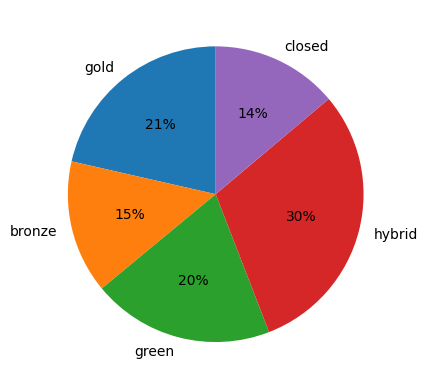

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt

oa_names = oa.keys()     # ["hybrid", "gold", ...]
oa_counts = oa.values()  # [5241, 3716, ...]

plot_type = "Matplotlib" # @param ["Matplotlib", "Plotly"]
if plot_type == "Matplotlib":
    plt.pie(
        oa_counts,
        labels=oa_names,
        startangle=90,
        autopct='%1.0f%%'
    )
    plt.show()
else:
    fig = px.pie(
        names=oa_names,
        values=oa_counts
    )
    fig.show()


## 6. Create a line chart showing the total number of publications and citations per year

To create a line chart, we need two arrays, one for the x-axis and one for the y-axis. In this case we plot the publication years that we collect from the works on the x-axis and the counts on the y-axis.

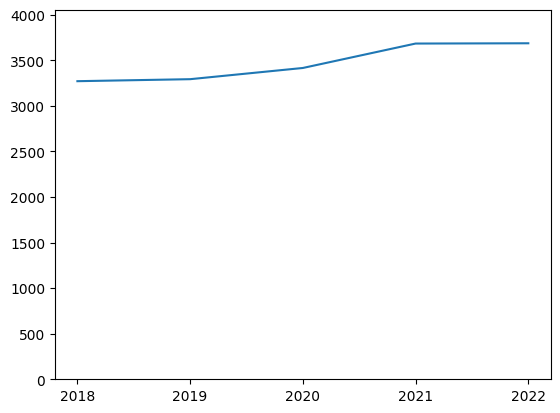

In [ ]:
# Collect the years and count the works per year
year_works_count = {}
for work in works:
    year = str(work.get("publication_year"))
    year_works_count[year] = year_works_count.get(year, 0) + 1

# Convert to table
year_works_count_list = year_works_count.items()

# Sort the table by the first column
year_works_count_sorted = sorted(year_works_count_list, key=lambda year: year[0])

# Populate the x-axis
years = [ year[0] for year in year_works_count_sorted ]
# Populate the y-axis
publications = [ year[1] for year in year_works_count_sorted ]

plot_type = "Matplotlib" # @param ["Matplotlib", "Plotly"]
if plot_type == "Matplotlib":
    plt.plot(years, publications)
    plt.ylim(0, max(publications) * 1.1)
    plt.show()
else:
    fig = px.line(x=years, y=publications)
    fig.show()

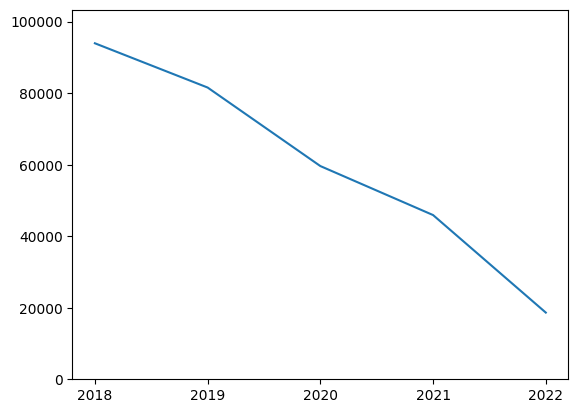

In [ ]:
year_cited_by_count = {}
for work in works:
    year = str(work.get("publication_year"))
    year_cited_by_count[year] = year_cited_by_count.get(year, 0) + work.get("cited_by_count", 0)

year_cited_by_count_list = year_cited_by_count.items()
year_cited_by_count_sorted = sorted(year_cited_by_count_list, key=lambda year: year[0])

years = [ year[0] for year in year_cited_by_count_sorted ]
citations = [ year[1] for year in year_cited_by_count_sorted ]

plot_type = "Matplotlib" # @param ["Matplotlib", "Plotly"]
if plot_type == "Matplotlib":
    plt.plot(years, citations)
    plt.ylim(0, max(citations) * 1.1)
    plt.show()
else:
    fig = px.line(x=years, y=citations)
    fig.show()


## 7. Create a world map showing the number of authorships per country

To create a world map of the authorships per country, we can use a choropleth map using the Plotly library.

We can simply count the countries per authorship per work. But we need to sanitize the countries as OpenAlex provides ISO-2 country codes, while
Plotly expects ISO-3 country codes. We can use the `country_converter` library for this.

To create the choropleth map we need a geographic indicator, in this case a list of ISO-3 country codes, and a color indicator, in this case the authorship count per country. Optionally we can also include the full name of the countries as a label.

In [ ]:
%pip install country_converter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
# Count the countries per authorship per work
countries = {}
for work in works:
    for authorship in work.get("authorships"):
        for country in authorship.get("countries"):
            countries[country] = countries.get(country, 0) + 1

# Optionally remove the Netherlands as a vast majority of Dutch authorships skew the data
remove_netherlands = True # @param {type:"boolean"}
if remove_netherlands:
    del countries["NL"]

import country_converter as coco
# Get the sanitized names from country_converer for the labels
countries_names = coco.convert([name for name in countries.keys()], to='name_short')
# Get ISO-3 codes from country_converer for the locations
countries_iso = coco.convert([name for name in countries.keys()], to='ISO3')
# Collect the counts for the colors on the map
countries_counts = [count for count in countries.values()]

fig = px.choropleth(
    hover_name=countries_names,
    locations=countries_iso,
    locationmode='ISO-3',
    color=countries_counts
)
fig.show()